# Clasificación con conjunto de datos sobre desinformación
Este cuaderno está basado en el trabajo del artículo ([Oehmichen et al. 2019](https://ieeexplore.ieee.org/document/8819953)), en el que se demuestra que las cuentas de Twitter que crearon y difundieron desinformación en las elecciones presidenciales de EE.UU. en 2016 exhibieron un comportamiento diferente a las cuentas normales. Estos hallazgos sugieren que la _ingenería_ de la desinformación parece explotar rasgos humanos como la reciprocidad y el sesgo de confirmación.

> A. Oehmichen, K. Hua, J. Amador Díaz López, M. Molina-Solana, J. Gómez-Romero and Y. Guo, "Not All Lies Are Equal. A Study Into the Engineering of Political Misinformation in the 2016 US Presidential Election," in IEEE Access, vol. 7, pp. 126305-126314, 2019, doi: [10.1109/ACCESS.2019.2938389](https://ieeexplore.ieee.org/document/8819953).

Los datos completos pueden descargarse de [Zenodo](https://zenodo.org/record/1048826).

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Cargar datos:

In [ ]:
import pandas as pd
from google.colab import files

uploaded = files.upload()
data_raw = pd.read_excel('twitter_fakenews_USElections_2016.xlsx')
data_raw.head()

Saving twitter_fakenews_USElections_2016.xlsx to twitter_fakenews_USElections_2016.xlsx


,is_fake_news,tweet_id,created_at,retweet_count,text,user_screen_name,user_verified,user_friends_count,user_followers_count,user_favourites_count,tweet_source,geo_coordinates_available,num_hashtags,num_mentions,num_urls,num_media
0,False,258641295487156224,Wed Oct 17 18:51:04 +0000 2012,1210,@realDonaldTrump YOU SHOULD BE PRESIDENT FOR S...,GHOSTofMEATBALL,False,396,804,91,TweetDeck,0,0,2,0,0
1,False,261135127055327233,Wed Oct 24 16:00:40 +0000 2012,1656,I literally pose half naked for a living and u...,chrissyteigen,True,4024,3983853,20973,Twitter for iPhone,0,0,2,0,0
2,False,264033382076407808,Thu Nov 01 15:57:18 +0000 2012,4688,@realDonaldTrump you are full of shit!,RalphGilles,True,759,29163,3298,Twitter for iPhone,0,0,2,0,0
3,False,265895586660757505,Tue Nov 06 19:17:02 +0000 2012,10418,@realDonaldTrump you're fucking retarded,TimmyWait,False,839,397,506,Twitter Web Client,0,0,2,0,0
4,False,265895723445411841,Tue Nov 06 19:17:35 +0000 2012,1930,@realDonaldTrump You are the stupidest man on ...,mattcale52,False,1184,1350,3364,Twitter for iPhone,0,0,2,0,0


Seleccionar subconjunto de interés:

In [ ]:
data = data_raw[data_raw['is_fake_news'] != 'UNKNOWN']

## Análisis exploratorio

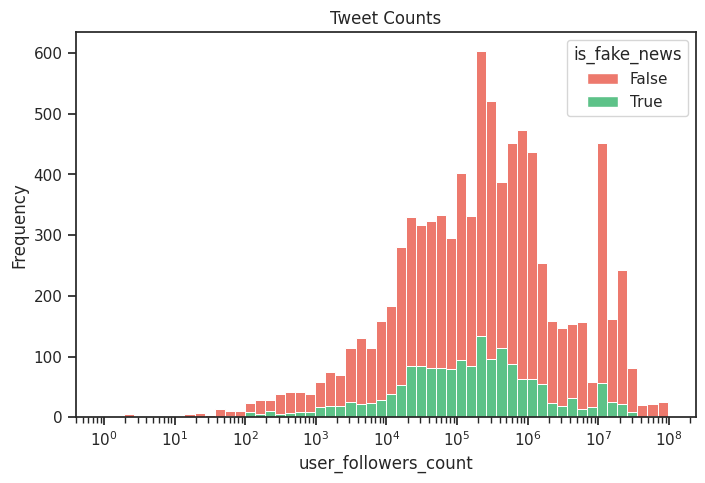

In [ ]:
plt.figure(figsize=(8, 5))
sns.set_theme(style="ticks")
sns.histplot(data, x='user_followers_count', hue='is_fake_news', log_scale=(True, False), multiple='stack', palette= sns.color_palette(['#E74C3C', '#27AE60']))
plt.xlabel('user_followers_count')
plt.ylabel('Frequency')
plt.title('Tweet Counts')
plt.show()

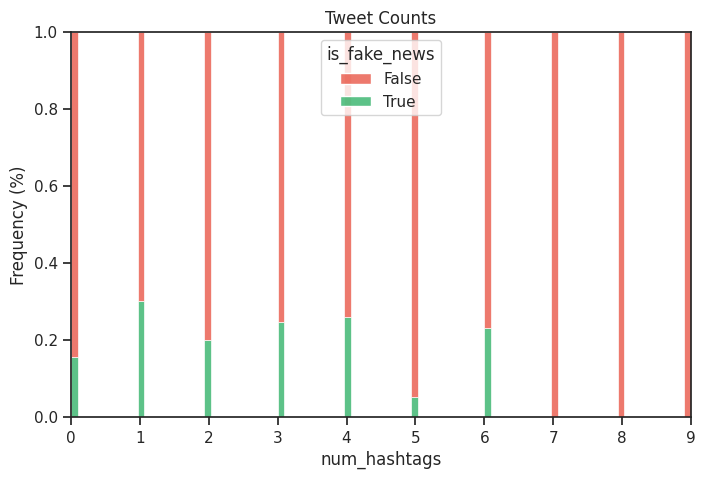

In [ ]:
plt.figure(figsize=(8, 5))
sns.set_theme(style="ticks")
sns.histplot(data, x='num_hashtags', hue='is_fake_news', multiple='fill', palette= sns.color_palette(['#E74C3C', '#27AE60']))
plt.xlabel('num_hashtags')
plt.ylabel('Frequency (%)')
plt.title('Tweet Counts')
plt.show()

## Ejercicio 1: Modelos de clasificación

***Actividad Práctica de las Fakes News***

Carga de los paquetes necesarios para la actividad

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.ensemble import VotingClassifier, BaggingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC


Carga y procesamiento de datos

In [ ]:
import pandas as pd
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
data_raw = pd.read_excel('twitter_fakenews_USElections_2016.xlsx')
data_raw

Saving twitter_fakenews_USElections_2016.xlsx to twitter_fakenews_USElections_2016 (4).xlsx
User uploaded file "twitter_fakenews_USElections_2016 (4).xlsx" with length 1488250 bytes


,is_fake_news,tweet_id,created_at,retweet_count,text,user_screen_name,user_verified,user_friends_count,user_followers_count,user_favourites_count,tweet_source,geo_coordinates_available,num_hashtags,num_mentions,num_urls,num_media
0,False,258641295487156224,Wed Oct 17 18:51:04 +0000 2012,1210,@realDonaldTrump YOU SHOULD BE PRESIDENT FOR S...,GHOSTofMEATBALL,False,396,804,91,TweetDeck,0,0,2,0,0
1,False,261135127055327233,Wed Oct 24 16:00:40 +0000 2012,1656,I literally pose half naked for a living and u...,chrissyteigen,True,4024,3983853,20973,Twitter for iPhone,0,0,2,0,0
2,False,264033382076407808,Thu Nov 01 15:57:18 +0000 2012,4688,@realDonaldTrump you are full of shit!,RalphGilles,True,759,29163,3298,Twitter for iPhone,0,0,2,0,0
3,False,265895586660757505,Tue Nov 06 19:17:02 +0000 2012,10418,@realDonaldTrump you're fucking retarded,TimmyWait,False,839,397,506,Twitter Web Client,0,0,2,0,0
4,False,265895723445411841,Tue Nov 06 19:17:35 +0000 2012,1930,@realDonaldTrump You are the stupidest man on ...,mattcale52,False,1184,1350,3364,Twitter for iPhone,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8996,False,834904228283969536,Thu Feb 23 23:14:14 +0000 2017,1467,So not only was @realDonaldTrump's campaign in...,KeithOlbermann,True,898,849848,9,Twitter for iPhone,0,0,2,0,0
8997,False,834935434144731136,Fri Feb 24 01:18:14 +0000 2017,8396,"Well @realDonaldTrump, from one Republican to ...",Caitlyn_Jenner,True,39,3927783,38,Twitter for iPhone,0,0,2,1,0
8998,False,834935842590294016,Fri Feb 24 01:19:51 +0000 2017,2257,How are you going to sit here and tell trans k...,coolbreeeze_,False,512,1499,5832,TweetDeck,0,0,1,1,0
8999,False,834940351894990848,Fri Feb 24 01:37:46 +0000 2017,3408,"the gag is, you only now care because his hate...",minajIust,False,200,1011,15732,Twitter for iPhone,0,0,1,1,0


Comprobación de los datos

In [ ]:
# Para ver el tipo de datos de la columna
print(data_raw['is_fake_news'].dtype)

# Verificar los valores únicos en la columna 'is_fake_news'
print(data_raw['is_fake_news'].unique())

# Eliminar filas donde 'is_fake_news' sea 'UNKNOWN'
data_raw = data_raw[data_raw['is_fake_news'] != 'UNKNOWN']

print(data_raw['is_fake_news'].dtype)

# Verificar los valores únicos en la columna 'is_fake_news'
print(data_raw['is_fake_news'].unique())

label_encoder = LabelEncoder()
data_raw['is_fake_news'] = label_encoder.fit_transform(data_raw['is_fake_news'])

print(data_raw['is_fake_news'].unique())

object
[False True 'UNKNOWN']
object
[False True]
[0 1]


<ipython-input-4-a954555cdaae>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_raw['is_fake_news'] = label_encoder.fit_transform(data_raw['is_fake_news'])


Árbol de decisión, KNN y Random Forest

int64
[0 1]
Best k: 8
Best cross-validated score: 0.80
Precisión en el conjunto de prueba: 0.7925840092699884
Evaluación KNN:
              precision    recall  f1-score   support

           0       0.82      0.96      0.89       696
           1       0.42      0.11      0.18       167

    accuracy                           0.80       863
   macro avg       0.62      0.54      0.53       863
weighted avg       0.74      0.80      0.75       863

Evaluación Árbol de Decisión:
              precision    recall  f1-score   support

           0       0.83      0.80      0.81       696
           1       0.27      0.31      0.28       167

    accuracy                           0.70       863
   macro avg       0.55      0.55      0.55       863
weighted avg       0.72      0.70      0.71       863

Evaluación Random Forest:
              precision    recall  f1-score   support

           0       0.83      0.95      0.88       696
           1       0.44      0.18      0.26       167



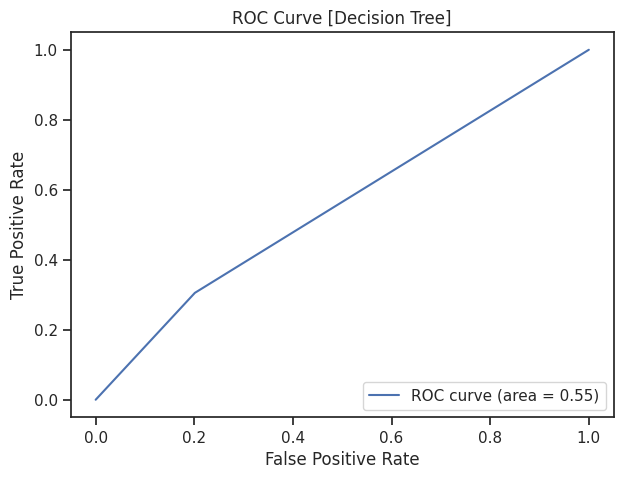

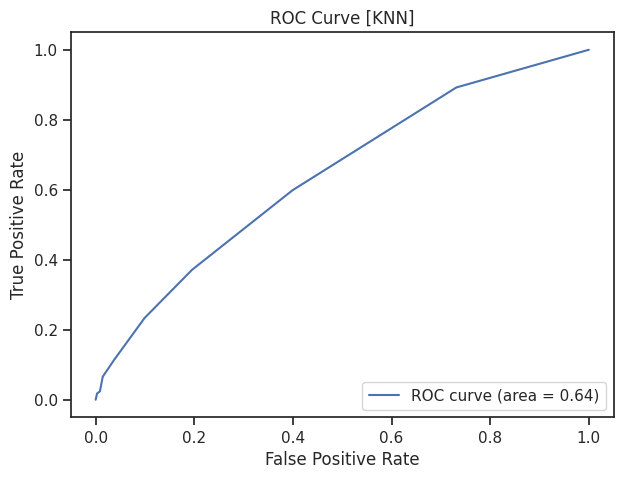

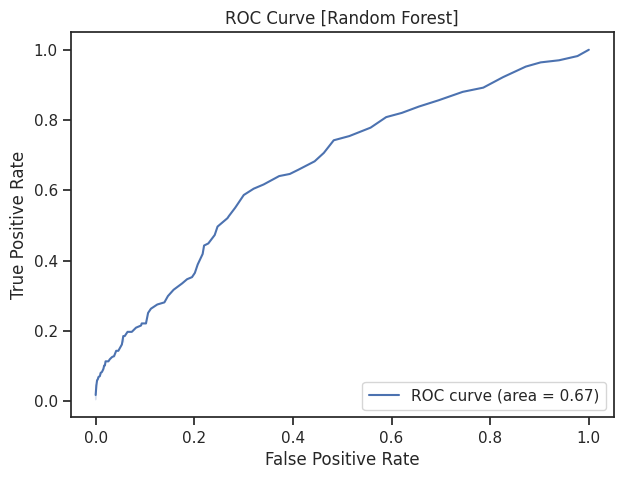

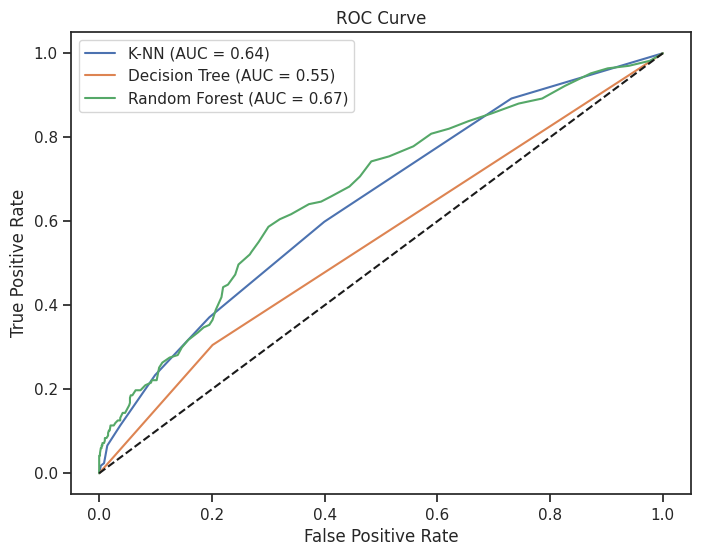

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_val_predict
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score


# Se escogen las columnas
data = data_raw [['is_fake_news',  'retweet_count', 'user_favourites_count', 'user_followers_count', 'num_hashtags', 'num_mentions',  'num_urls',  'num_media' ]].copy()
df = data_raw.copy()

# Para ver el tipo de datos de la columna
print(data['is_fake_news'].dtype)

# Verificar los valores únicos en la columna 'is_fake_news'
print(data['is_fake_news'].unique())

# Eliminar filas donde 'is_fake_news' sea 'UNKNOWN'
data = data[data['is_fake_news'] != 'UNKNOWN']

# Convertir la variable 'is_fake_news' en valores numéricos (0, 1) con Label Encoding
label_encoder = LabelEncoder()
data['is_fake_news'] = label_encoder.fit_transform(data['is_fake_news'])

# Separar las variables independientes (X) y la variable dependiente (y)
X = data.drop('is_fake_news', axis=1)  # Variables predictoras
y = data['is_fake_news']  # Variable objetivo

#Se dividen los datos en subconjuntos de entrenamiento (80%) y validación (20%)
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.2, random_state=42)

#Se Divide el resto (20%) en validación (10%) y prueba (10%)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=0)

# Normalizar las características para KNN (es importante porque KNN es sensible a la escala)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Cross Validation
X_cv = pd.concat([X_train, X_val], axis=0)
y_cv = pd.concat([y_train, y_val], axis=0)
param_grid = {'n_neighbors': range(1, 11)}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_cv, y_cv)

# Se muestran la mejor K y el puntaje del CV
print(f"Best k: {grid_search.best_params_['n_neighbors']}")
print(f"Best cross-validated score: {grid_search.best_score_:.2f}")

# Evaluar el modelo con el mejor número de estimadores en el conjunto de prueba
best_bagging = grid_search.best_estimator_
accuracy = best_bagging.score(X_test, y_test)
print("Precisión en el conjunto de prueba:", accuracy)

# Modelo KNN, estimando la mejor k
knn = KNeighborsClassifier(n_neighbors= grid_search.best_params_['n_neighbors'])
knn.fit(X_train_scaled, y_train)

# Modelo Árbol de Decisión
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)
y_pred_tree = decision_tree.predict(X_test)
y_prob_tree = decision_tree.predict_proba(X_test)[:, 1]

# Modelo Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# Predicciones con ambos modelos
y_pred_knn = knn.predict(X_test_scaled)
y_pred_tree = decision_tree.predict(X_test)
y_pred_rf = rf.predict(X_test)

# Evaluar los modelos
print("Evaluación KNN:")
print(classification_report(y_test, y_pred_knn))

print("Evaluación Árbol de Decisión:")
print(classification_report(y_test, y_pred_tree))

print("Evaluación Random Forest:")
print(classification_report(y_test, y_pred_rf))

# Comparar las precisiones de ambos modelos
print(f"Precisión KNN: {accuracy_score(y_test, y_pred_knn)}")
print(f"Precisión Árbol de Decisión: {accuracy_score(y_test, y_pred_tree)}")
print(f"Precisión Random Forest: {accuracy_score(y_test, y_pred_rf)}")

print(f"Precisión KNN: {precision_score(y_test, y_pred_knn)}")
print(f"Precisión Árbol de Decisión: {precision_score(y_test, y_pred_tree)}")
print(f"Precisión Random Forest: {precision_score(y_test, y_pred_rf)}")

print(f"Recall KNN: {recall_score(y_test, y_pred_knn)}")
print(f"Recall Árbol de Decisión: {recall_score(y_test, y_pred_tree)}")
print(f"Recall Random Forest: {recall_score(y_test, y_pred_rf)}")

X_cv = pd.concat([X_train, X_val], axis=0)
y_cv = pd.concat([y_train, y_val], axis=0)

dt_cv = DecisionTreeClassifier()
cv_scores = cross_val_score(dt_cv, X_cv, y_cv, cv=5, scoring='accuracy')

print(f'Cross-validation scores DT: {cv_scores}')
print(f'Best cross-validation score DT: {cv_scores.max():.2f}')
print(f'Mean cross-validation score DT: {cv_scores.mean():.2f}')

knn_cv = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'])
knn_scores = cross_val_score(knn_cv, X_cv, y_cv, cv=5, scoring='accuracy')

y_pred_prob_tree = decision_tree.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_tree)
roc_auc = roc_auc_score(y_test, y_pred_prob_tree)

print(f'Cross-validation scores KNN: {knn_scores}')
print(f'Best cross-validation score KNN: {knn_scores.max():.2f}')
print(f'Mean cross-validation score KNN: {knn_scores.mean():.2f}')

rf_cv = RandomForestClassifier(n_estimators=100, random_state=42)
rf_scores = cross_val_score(rf_cv, X_cv, y_cv, cv=5, scoring='accuracy')

print(f'Cross-validation scores RF: {rf_scores}')
print(f'Best cross-validation score RF: {rf_scores.max():.2f}')
print(f'Mean cross-validation score RF: {rf_scores.mean():.2f}')

# Creación de gráficas de Curvas ROC por separado

#Decision Tree
plt.figure(figsize=(7, 5))
sns.set_theme(style="ticks")
sns.lineplot(x=fpr, y=tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve [Decision Tree]')
plt.legend(loc='lower right')
plt.show()

#KNN

y_pred_prob_knn = knn.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_knn)
roc_auc = roc_auc_score(y_test, y_pred_prob_knn)
plt.figure(figsize=(7, 5))
sns.set_theme(style="ticks")
sns.lineplot(x=fpr, y=tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve [KNN]')
plt.legend(loc='lower right')
plt.show()

# Random Forest

y_pred_prob_rf = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_rf)
roc_auc = roc_auc_score(y_test, y_pred_prob_rf)
plt.figure(figsize=(7, 5))
sns.set_theme(style="ticks")
sns.lineplot(x=fpr, y=tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve [Random Forest]')
plt.legend(loc='lower right')
plt.show()

# Curvas ROC comparadas entre los tres modelos
def plot_roc_curve(y_test, y_prob, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.figure(figsize=(8, 6))
plot_roc_curve(y_test, y_pred_prob_knn, "K-NN")
plot_roc_curve(y_test, y_pred_prob_tree, "Decision Tree")
plot_roc_curve(y_test, y_prob_rf, "Random Forest")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Comparación con Voting

<ipython-input-6-1b374763a690>:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame([{


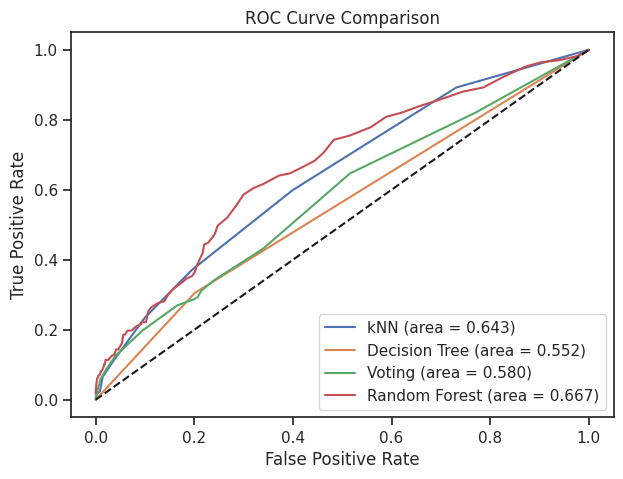

In [ ]:
#Selección de las métricas

metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

#Aplicación del modelo Voting

voting_clf = VotingClassifier(
    estimators=[('knn', KNeighborsClassifier(n_neighbors=7)),
                ('dt', DecisionTreeClassifier())
                ])
voting_clf.fit(X_train, y_train)

y_pred_voting = voting_clf.predict(X_test)

# Datos a obtener
accuracy_voting = accuracy_score(y_test, y_pred_voting)
precision_voting = precision_score(y_test, y_pred_voting)
recall_voting = recall_score(y_test, y_pred_voting)
f1_voting = f1_score(y_test, y_pred_voting)

#Clasification Report
metrics_df = pd.concat([metrics_df, pd.DataFrame([{
    'Model': 'Voting Classifier',
    'Accuracy': accuracy_voting,
    'Precision': precision_voting,
    'Recall': recall_voting,
    'F1 Score': f1_voting
}])], ignore_index=True)

metrics_df
voting_clf = VotingClassifier(
    estimators=[('knn', KNeighborsClassifier(n_neighbors=7)),
                ('dt', DecisionTreeClassifier())
                ],
    voting="soft")
voting_clf.fit(X_train, y_train)

y_test_pred_prob_voting = voting_clf.predict_proba(X_test)[:, 1]
fpr_voting, tpr_voting, _ = roc_curve(y_test, y_test_pred_prob_voting)
roc_auc_voting = roc_auc_score(y_test, y_test_pred_prob_voting)

metrics_df.loc[2, 'ROC AUC'] = roc_auc_voting

metrics_df

# Curvas ROC de cada modelo anterior

y_pred_prob_knn = knn.predict_proba(X_test_scaled)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_prob_knn)
roc_auc_knn = roc_auc_score(y_test, y_pred_prob_knn)

y_pred_prob_tree = decision_tree.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_prob_tree)
roc_auc_dt = roc_auc_score(y_test, y_pred_prob_tree)

y_prob_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)

#Gráfica de ROC Curve Comparison entre KNN, Decision Tree y Voting
plt.figure(figsize=(7, 5))
sns.set_theme(style="ticks")
sns.lineplot(x=fpr_knn, y=tpr_knn, label='kNN (area = {:.3f})'.format(roc_auc_knn))
sns.lineplot(x=fpr_dt, y=tpr_dt, label='Decision Tree (area = {:.3f})'.format(roc_auc_dt))
sns.lineplot(x=fpr_voting, y=tpr_voting, label='Voting (area = {:.3f})'.format(roc_auc_voting))
sns.lineplot(x=fpr_rf, y=tpr_rf, label='Random Forest (area = {:.3f})'.format(roc_auc_rf))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='lower right')
plt.show()

Comparación con Bagging

<ipython-input-7-7fc5253fd897>:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, pd.DataFrame([{


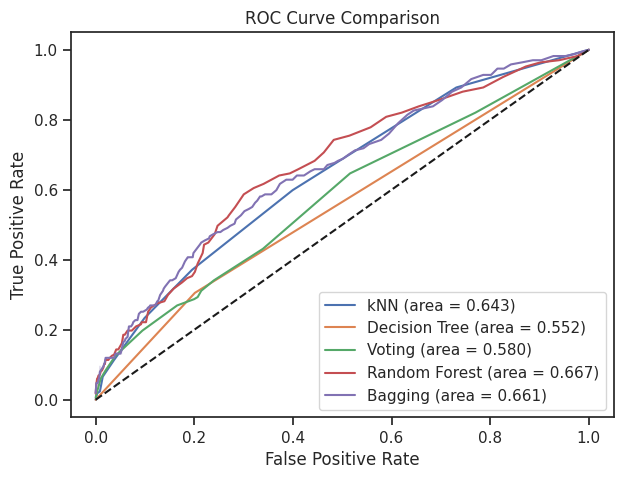

In [ ]:
#Se cargan ciertas librerías que faltaban

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report


# CV Report
def cross_validation_report(model, X, y, cv=5):
    y_pred = cross_val_predict(model, X, y, cv=cv)
    print(classification_report(y, y_pred))

metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Definir el modelo BaggingClassifier
bagging = BaggingClassifier(estimator=DecisionTreeClassifier())
bagging_clf = BaggingClassifier(estimator=DecisionTreeClassifier(),n_estimators=200)
bagging_clf.fit(X_train, y_train)

y_pred_bagging = bagging_clf.predict(X_test)
y_pred_prob_bagging = bagging_clf.predict_proba(X_test)[:, 1]

accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
precision_bagging = precision_score(y_test, y_pred_bagging)
recall_bagging = recall_score(y_test, y_pred_bagging)
f1_bagging = f1_score(y_test, y_pred_bagging)
roc_auc_bagging = roc_auc_score(y_test, y_pred_prob_bagging)
fpr_bagging, tpr_bagging, _ = roc_curve(y_test, y_pred_prob_bagging)



metrics_df = pd.concat([metrics_df, pd.DataFrame([{
    'Model': 'Bagging Classifier',
    'Accuracy': accuracy_bagging,
    'Precision': precision_bagging,
    'Recall': recall_bagging,
    'F1 Score': f1_bagging,
    'ROC AUC': roc_auc_bagging
}])], ignore_index=True)

metrics_df

# Grafica comparando todos los modelos
plt.figure(figsize=(7, 5))
sns.set_theme(style="ticks")
sns.lineplot(x=fpr_knn, y=tpr_knn, label='kNN (area = {:.3f})'.format(roc_auc_knn))
sns.lineplot(x=fpr_dt, y=tpr_dt, label='Decision Tree (area = {:.3f})'.format(roc_auc_dt))
sns.lineplot(x=fpr_voting, y=tpr_voting, label='Voting (area = {:.3f})'.format(roc_auc_voting))
sns.lineplot(x=fpr_rf, y=tpr_rf, label='Random Forest (area = {:.3f})'.format(roc_auc_rf))
sns.lineplot(x=fpr_bagging, y=tpr_bagging, label='Bagging (area = {:.3f})'.format(roc_auc_bagging))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()




Comparación con Boosting

Validation Accuracy (Gradient Boosting): 0.81
Best parameters (Gradient Boosting): {'max_depth': 3, 'n_estimators': 300}
Best cross-validated score (Gradient Boosting): 0.80
Test Accuracy (Gradient Boosting): 0.81
ROC AUC on test set (Gradient Boosting): 0.66


<ipython-input-8-e8a857344bed>:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


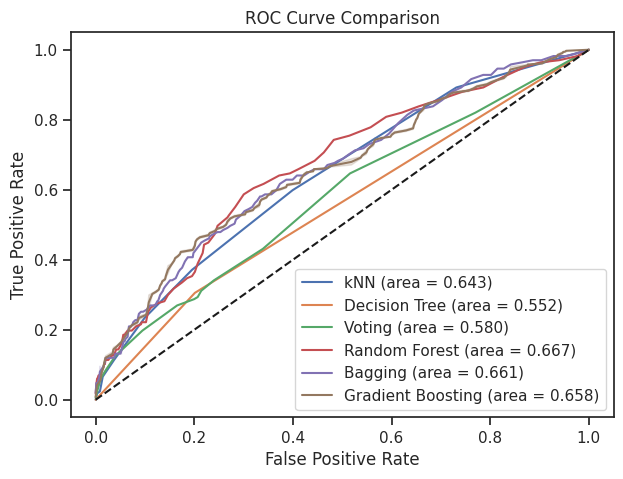

In [ ]:
gb_model = GradientBoostingClassifier(n_estimators=100)
gb_model.fit(X_train, y_train)

y_val_pred_gb = gb_model.predict(X_val)
val_accuracy_gb = accuracy_score(y_val, y_val_pred_gb)
print(f'Validation Accuracy (Gradient Boosting): {val_accuracy_gb:.2f}')

X_cv = pd.concat([X_train, X_val], axis=0)
y_cv = pd.concat([y_train, y_val], axis=0)

param_grid = {'n_estimators': [300], 'max_depth': [3, 4, 5, 6]}
grid_search_gb = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search_gb.fit(X_cv, y_cv)

print(f"Best parameters (Gradient Boosting): {grid_search_gb.best_params_}")
print(f"Best cross-validated score (Gradient Boosting): {grid_search_gb.best_score_:.2f}")

best_gb_model = grid_search_gb.best_estimator_

y_test_pred_gb = best_gb_model.predict(X_test)
test_accuracy_gb = accuracy_score(y_test, y_test_pred_gb)
print(f"Test Accuracy (Gradient Boosting): {test_accuracy_gb:.2f}")

y_test_pred_proba_gb = best_gb_model.predict_proba(X_test)[:, 1]
test_roc_auc_gb = roc_auc_score(y_test, y_test_pred_proba_gb)

def add_results(results_df, model_name, accuracy, roc_auc):
    new_row = pd.DataFrame({'Model': [model_name], 'Accuracy': [accuracy], 'ROC AUC': [roc_auc]})
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    return results_df

print(f"ROC AUC on test set (Gradient Boosting): {test_roc_auc_gb:.2f}")
# Define results_df before calling add_results
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'ROC AUC'])
results_df = add_results(results_df, 'Gradient Boosting', test_accuracy_gb, test_roc_auc_gb)
results_df

# Curva de Boosting
y_pred_proba_gb = best_gb_model.predict_proba(X_test)[:, 1]
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_proba_gb)


# Grafica comparando todos los modelos
plt.figure(figsize=(7, 5))
sns.set_theme(style="ticks")
sns.lineplot(x=fpr_knn, y=tpr_knn, label='kNN (area = {:.3f})'.format(roc_auc_knn))
sns.lineplot(x=fpr_dt, y=tpr_dt, label='Decision Tree (area = {:.3f})'.format(roc_auc_dt))
sns.lineplot(x=fpr_voting, y=tpr_voting, label='Voting (area = {:.3f})'.format(roc_auc_voting))
sns.lineplot(x=fpr_rf, y=tpr_rf, label='Random Forest (area = {:.3f})'.format(roc_auc_rf))
sns.lineplot(x=fpr_bagging, y=tpr_bagging, label='Bagging (area = {:.3f})'.format(roc_auc_bagging))
sns.lineplot(x=fpr_gb, y=tpr_gb, label='Gradient Boosting (area = {:.3f})'.format(test_roc_auc_gb))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

Validaciones cruzadas

In [ ]:
#Se muestran todas las valoraciones cruzadas
print("Validación Cruzada - KNN")
cross_validation_report(knn, X, y)

print("Validación Cruzada - Árbol de Decisiones")
cross_validation_report(decision_tree, X, y)

print("Validación Cruzada - Voting")
cross_validation_report(voting_clf, X, y)

print("Validación Cruzada - Bagging")
cross_validation_report(bagging_clf, X, y)

print("Validación Cruzada - Random Forest")
cross_validation_report(rf, X, y)

print("Validación Cruzada - Gradient Boosting")
cross_validation_report(gb_model, X, y)


# Informe de clasificación (Classification Report)
def classification_report_model(y_test, y_pred, model_name):
    print(f'Informe de Clasificación - {model_name}')
    print(classification_report(y_test, y_pred))
    print()



Validación Cruzada - KNN
              precision    recall  f1-score   support

           0       0.80      0.96      0.87      6897
           1       0.27      0.06      0.10      1729

    accuracy                           0.78      8626
   macro avg       0.54      0.51      0.49      8626
weighted avg       0.70      0.78      0.72      8626

Validación Cruzada - Árbol de Decisiones
              precision    recall  f1-score   support

           0       0.81      0.76      0.79      6897
           1       0.25      0.31      0.27      1729

    accuracy                           0.67      8626
   macro avg       0.53      0.54      0.53      8626
weighted avg       0.70      0.67      0.69      8626

Validación Cruzada - Voting
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      6897
           1       0.25      0.26      0.26      1729

    accuracy                           0.70      8626
   macro avg       0.53      0.53 

Gráficas de las matrices de confusión

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


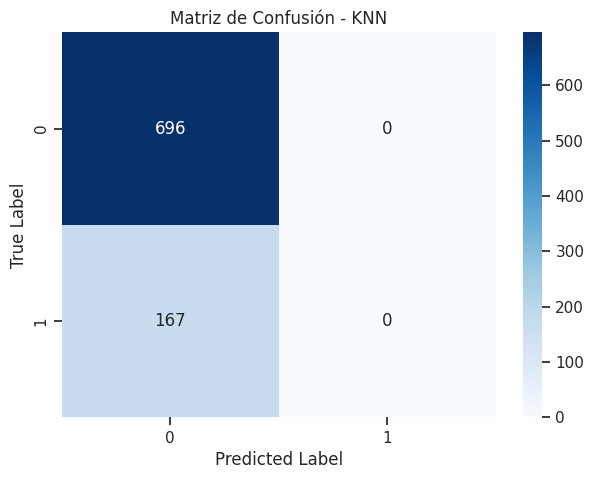

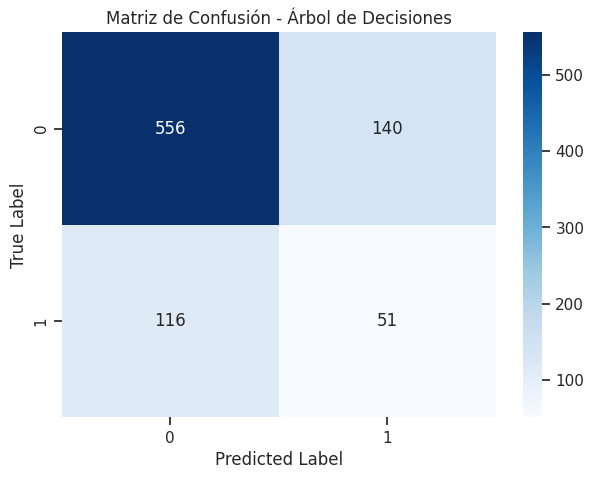

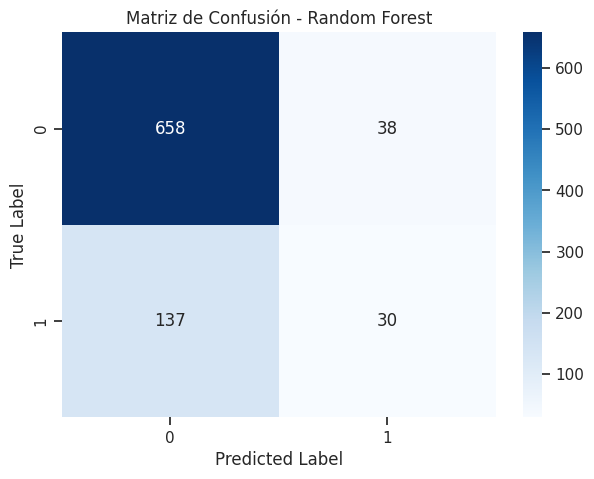

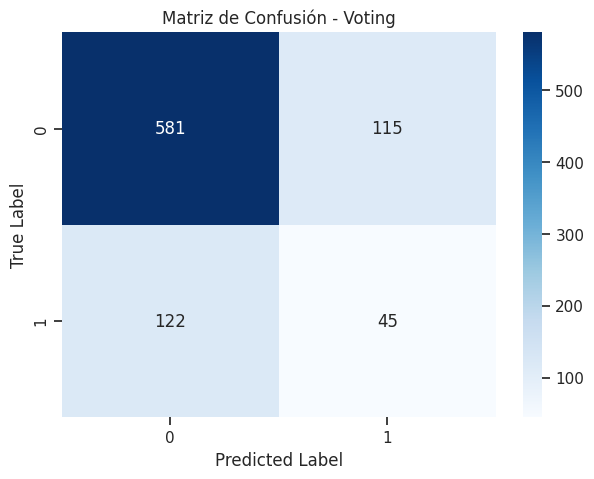

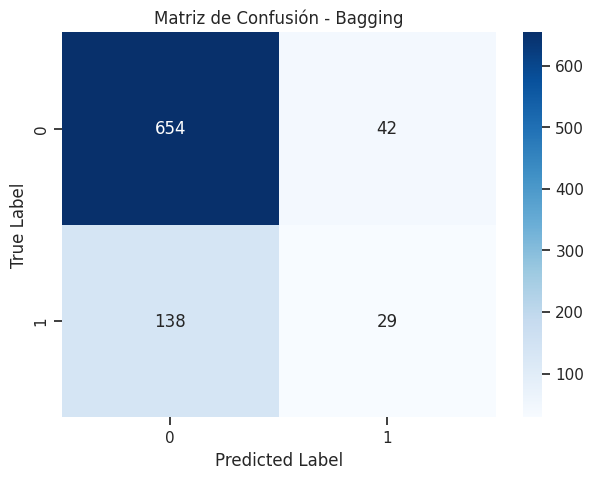

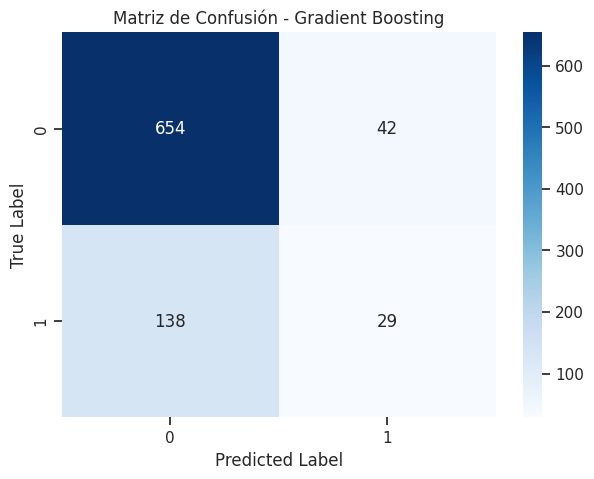

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predecir probabilidades para cada modelo
y_pred_knn = knn.predict_proba(X_test)[:, 1]
y_pred_tree = decision_tree.predict_proba(X_test)[:, 1]
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred_voting = voting_clf.predict_proba(X_test)[:, 1]
y_pred_bagging = bagging_clf.predict_proba(X_test)[:, 1]
y_pred_gb = gb_model.predict_proba(X_test)[:, 1]


# Matrices de confusión
y_pred_knn_class = knn.predict(X_test)
y_pred_tree_class = decision_tree.predict(X_test)
y_pred_rf_class = rf.predict(X_test)
y_pred_voting_class = voting_clf.predict(X_test)
y_pred_bagging_class = bagging_clf.predict(X_test)
y_pred_gb_class = gb_model.predict(X_test)

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Gráfica de matrices de confusión
plot_confusion_matrix(y_test, y_pred_knn_class, 'Matriz de Confusión - KNN')
plot_confusion_matrix(y_test, y_pred_tree_class, 'Matriz de Confusión - Árbol de Decisiones')
plot_confusion_matrix(y_test, y_pred_rf_class, 'Matriz de Confusión - Random Forest')
plot_confusion_matrix(y_test, y_pred_voting_class, 'Matriz de Confusión - Voting')
plot_confusion_matrix(y_test, y_pred_bagging_class, 'Matriz de Confusión - Bagging')
plot_confusion_matrix(y_test, y_pred_bagging_class, 'Matriz de Confusión - Gradient Boosting')


### Conclusiones


**Resumen:**

Bagging tiene el mayor AUC, indicando mejor rendimiento. KNN destaca en precisión pero tiene bajo recall, mientras que Random Forest (RF) mejora en recall sin perder precisión. Decision Tree tiene mayor recall pero menor precisión. RF obtiene la mejor puntuación en validación cruzada.

**Elección final:**

RF es el mejor modelo por su equilibrio entre precisión y recall, además de su buen desempeño en validación cruzada. Aunque Bagging tiene un AUC ligeramente superior, RF es más efectivo para la clasificación general.






Redes Neuronales

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(10, 10), random_state=0)
mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(10, 10), random_state=0)

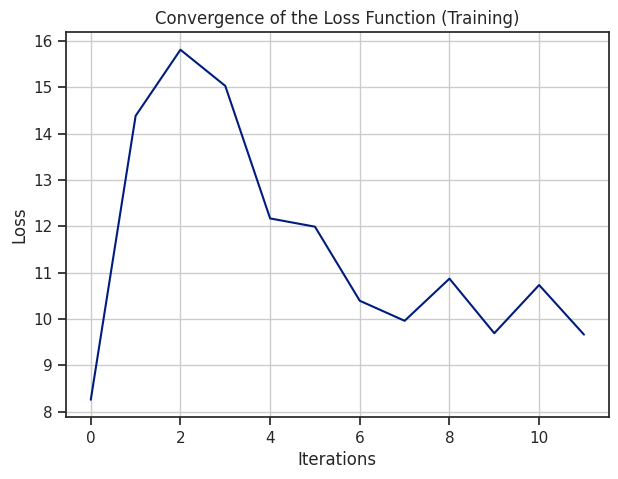

In [ ]:
plt.figure(figsize=(7, 5))
sns.set_theme(style="ticks", palette="dark")
sns.lineplot(data=mlp.loss_curve_)
plt.title('Convergence of the Loss Function (Training)')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [ ]:
y_val_pred = mlp.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))


Accuracy: 0.8053302433371958
              precision    recall  f1-score   support

           0       0.81      0.99      0.89       700
           1       0.27      0.02      0.03       163

    accuracy                           0.81       863
   macro avg       0.54      0.50      0.46       863
weighted avg       0.71      0.81      0.73       863



In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier

param_grid = {
    'hidden_layer_sizes': [(10, 10), (20, 20), (30, 30)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
}

random_search = RandomizedSearchCV(estimator=MLPClassifier(max_iter=200, random_state=42),  # Reducir max_iter para la búsqueda
                                param_distributions=param_grid,  # Usar param_distributions para RandomizedSearchCV
                                n_iter=20,  # Número de combinaciones aleatorias a probar
                                scoring='accuracy',
                                cv=5,
                                n_jobs=-1)  # Paralelización

random_search.fit(X_train, y_train)

print("Best parameters: ", random_search.best_params_)
print("Best cross-validated score: {:.2f}".format(random_search.best_score_))

# Volver a entrenar con los mejores parámetros y max_iter completo
best_mlp = MLPClassifier(max_iter=1000, random_state=42, **random_search.best_params_)
best_mlp.fit(X_train, y_train)

Best parameters:  {'solver': 'sgd', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (10, 10), 'alpha': 0.0001, 'activation': 'tanh'}
Best cross-validated score: 0.80


MLPClassifier(activation='tanh', hidden_layer_sizes=(10, 10),
              learning_rate='adaptive', max_iter=1000, random_state=42,
              solver='sgd')

In [ ]:
param_grid = {
    'hidden_layer_sizes': [(10, 10), (20, 20), (30, 30)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
}

grid_search = GridSearchCV(estimator=MLPClassifier(max_iter=1000, random_state=42),
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5)

grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best cross-validated score:  {:.2f}".format(grid_search.best_score_))

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Best parameters:  {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 10), 'learning_rate': 'constant', 'solver': 'sgd'}
Best cross-validated score:  0.80


Test Accuracy (Neural Network): 0.81


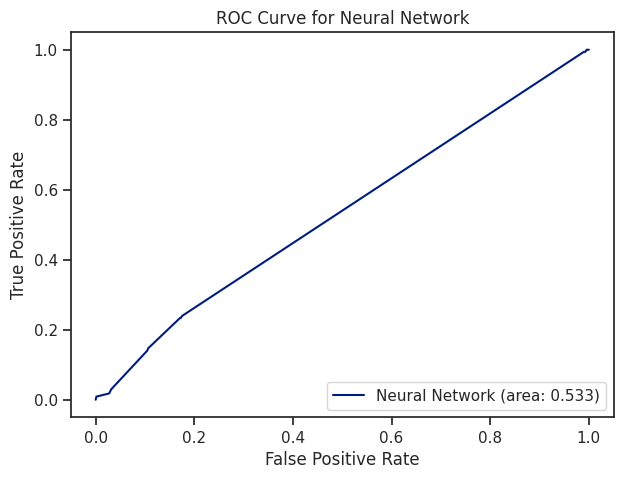

In [ ]:
best_mlp_model = grid_search.best_estimator_

y_test_pred_nn = best_mlp_model.predict(X_test)
test_accuracy_nn = accuracy_score(y_test, y_test_pred_nn)
print(f"Test Accuracy (Neural Network): {test_accuracy_nn:.2f}")

y_test_pred_proba_nn = best_mlp_model.predict_proba(X_test)[:, 1]
test_roc_auc_nn = roc_auc_score(y_test, y_test_pred_proba_nn)

fpr_nn, tpr_nn,   _ = roc_curve(y_test, y_test_pred_proba_nn)

plt.figure(figsize=(7, 5))
sns.set_theme(style="ticks", palette="dark")
sns.lineplot(x=fpr_nn, y=tpr_nn, label=f'Neural Network (area: {test_roc_auc_nn:.3f})', errorbar=None)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Neural Network')
plt.legend(loc='lower right')
plt.show()

Conclusiones

La gráfica Convergence of the Loss Function (Training) muestra la evolución de la función de pérdida (loss) en el entrenamiento. En esta se observa un aumento inicial del loss, lo cual puede indicar una mala inicialización de pesos o un aprendizaje inestable.

Luego, el loss disminuye gradualmente pero con fluctuaciones, lo que sugiere que el modelo no está convergiendo de manera óptima o que el proceso de optimización tiene ruido.

En lo relativo a la Curva ROC y área bajo la curva (AUC), se representa una relación entre la tasa de falsos positivos y la tasa de verdaderos positivos Así, el área bajo la curva (AUC) es de 0.533, lo que indica que el modelo tiene un rendimiento malo porque solo es algo superior al azar (0.5).
En consecuencia, la red neuronal no es efectiva para discriminar entre clases.

En lo que concierne a las métricas de clasificación.
* Primero el accuracy (0.805) parece indicar que el modelo acierta el 80.5% de  las veces, pero no puede ser así en el caso de que haya un desbalance de clases.
* Segundo, para la clase 0 (mayoría), la precisión es alta (0.81) y el recall es excelente (0.99), lo que significa que casi todas las instancias de la clase 0 son correctamente identificadas. Sin embargo, para la clase 1 (minoritaria), la precisión es baja (0.27) y el recall es muy bajo (0.02), indicando que el modelo apenas detecta los casos positivos. Este hecho mantienen las deficiencias observadas en la actividad anterior.
*Tercero, el F1-score muestra un rendimiento bajo en la clase 1, confirmando el problema en la detección de la minoría.

En definitiva, la red neuronal está sesgada hacia la clase mayoritaria y no generaliza bien a la clase 1. Una posible explicación es que el dataset esté desbalanceado, y el modelo necesita estrategias como reajuste de pesos, oversampling de la clase 1 o uso de otras métricas de evaluación. También podría ser útil ajustar hiperparámetros, cambiar la arquitectura de la red o probar otras técnicas de optimización.